# 4.2 보스턴 주택 가격 예측
- p.113~
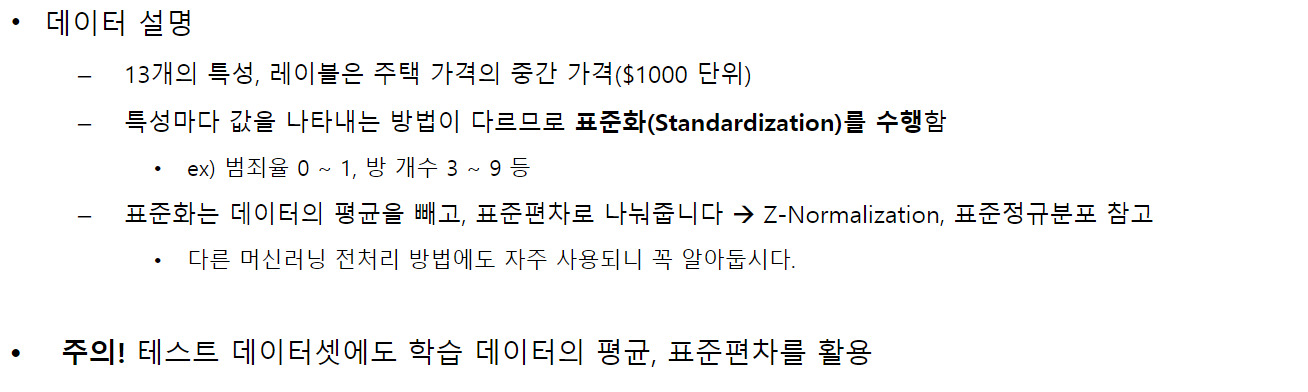

## 4.2.1 데이터 살펴보기

In [2]:
from tensorflow.keras.datasets.boston_housing import load_data

# 데이터를 다운받습니다.
(x_train, y_train), (x_test, y_test) = load_data(path='boston_housing.npz',
                                                 test_split=0.2,
                                                 seed=777)

65536/57026 [==================================] - 0s 0us/step


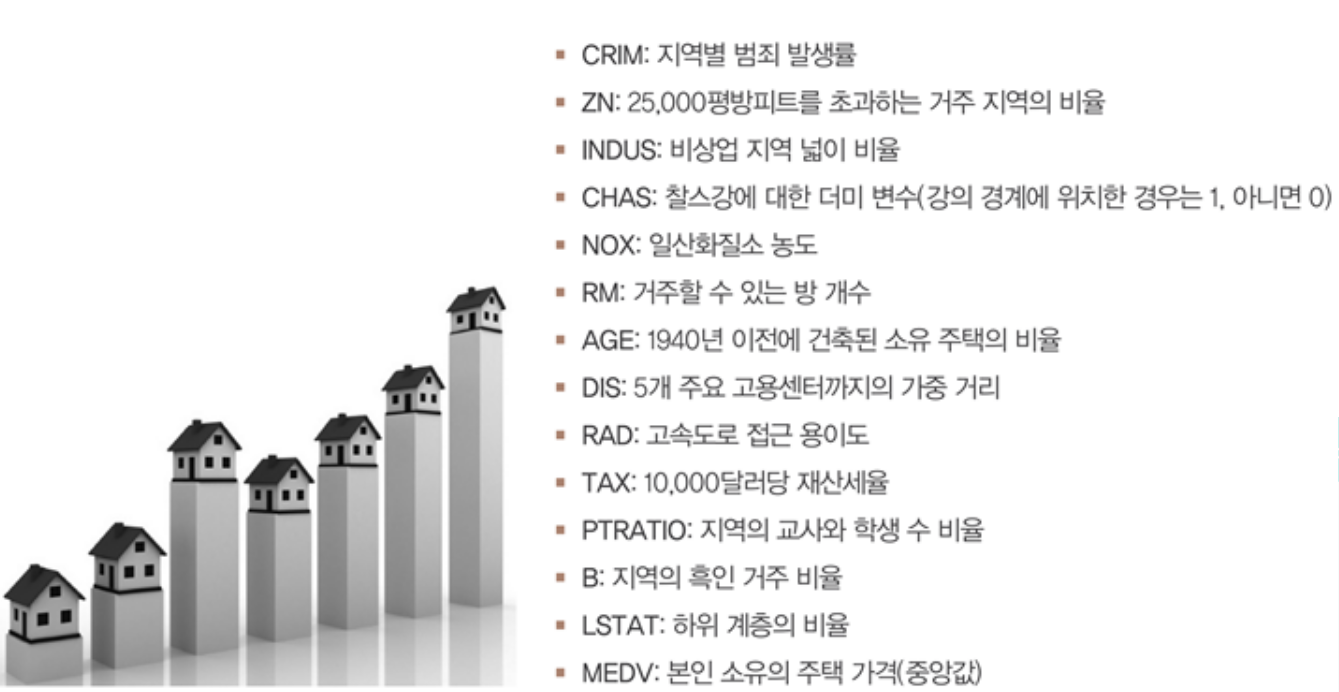

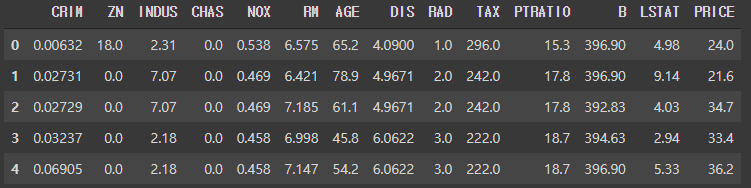

- 데이터 형태 확인

In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(404, 13) (404,)
(102, 13) (102,)


- 데이터 전처리 및 검증 데이터셋 만들기

In [21]:
import numpy as np

# 데이터 표준화
mean = np.mean(x_train, axis = 0)
std = np.std(x_train, axis = 0)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std # 주의) 학습 데이터셋의 평균과 표준편차를 사용하여 표준화함.

# 훈련 데이터셋과 검증 데이터셋으로 나눕니다.
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size = 0.33, 
                                                  random_state = 777)

## 4.2.2 모델 구성하기
- 모델의 마지막 Dense 층에서 별도의 활성화 함수를 사용하지 않음
  - 인자를 설정하지 않은 경우, default는 ‘linear’로 설정
- 손실 함수는 회귀 문제에서 주로 사용되는 평균 제곱 오차(MSE; Mean Squared Error)를 사용

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

# 입력 데이터의 형태를 꼭 명시해야 합니다.
# 13차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (13, ))) # x개수 숫자 안맞으면 error, 첫번째 층은 activation을 생략하기도 함
model.add(Dense(32, activation = 'relu')) # 32개의 출력을 가지는 Dense 층, 이 층은 필수 아님
# model.add를 몇 개를 더 하든 상관없음. 단, activation은 relu를 함.
# model.add(dropout(0.25)) # w 25%를 없애겠다. dropout은 레이어 사이사이에 맘껏 넣을 수 있음

model.add(Dense(1)) # 하나의 값을 출력합니다. ==> 최종 출력층, 선형회귀는 1개, 활성화함수는 생략 가능

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae', 'acc'])
# MSE는 손실함수로써 쓰이고 MAE는 평가지표로써 사용된다. 

In [23]:
model.summary()
# Param 구하는 공식 => dense수*input + dense수
# 1번층 Dense(64)는 13개의 w값과 1개의 b를 갖는 14개의 param(선)이 64개 있음 => 14*64=896개의 param이 나옴(최종 dense만큼 node가 나옴)
        # => 10*13+10
# 2번층 Dense(32)는 1번층 dense의 64개의 노드가 input값이 됨, 64개의 w와 1개의 b가 있음. 한 세트는 65개임*32= 2080개의 param
        # => 5*10*5
# 3번층 Dense(1)은 2번층 dense 32개가 input임. (32개의 w, 1개의 b => 총33개)
        # => 1*32+1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.get_weights(). # 모델의 가중치 값

In [24]:
len(model.get_weights()[0]), len(model.get_weights()[1])

(13, 64)

## 4.2.3 모델 학습 및 평가

In [26]:
# 오버피팅(가중치가 훈련데이터에만 잘 맞는 경우)를 확인하는 방법
# 훈련데이터의 loss값은 줄어드는데 검증데이터의 loss값은 늘어나는 경우
# 오버피팅이 있을 때 해결방법
    # dense 수를 줄이거나, 모델의 add를 줄이거나, epochs를 줄이거나, 모델 add 사이에 dropout을 넣거나, 배치를 크게 하거나, 러닝레이트값을 크게 하는 방법 등
# w,b 갱신은 훈련데이터하고만 작업함/ 검증이나 테스트 데이터는 w,b를 넣어서 계산만 함

history = model.fit(x_train, y_train, 
                    epochs = 300, 
                    validation_data = (x_val, y_val), # 검증데이터: 훈련데이터의 몇%로 하여 사용(validation_split) or 데이터 셋을 따로 정의(validation_data) or 보통은 테스트 데이터를 많이 넣음.
                    verbose=0)

<Figure size 864x288 with 0 Axes>

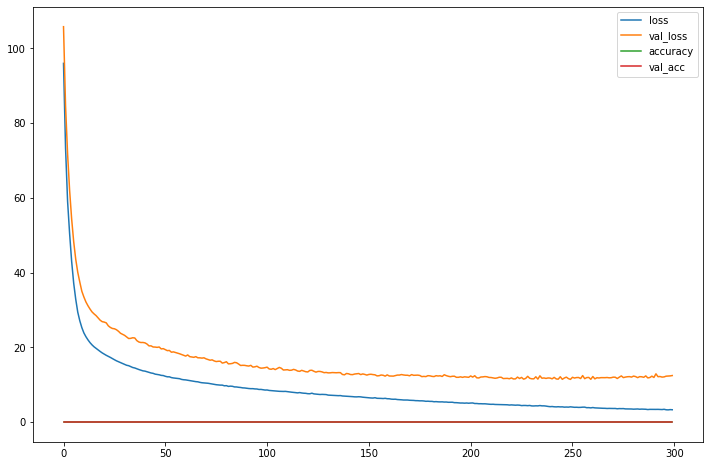

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()
# val_loss가 감소하다가 증가하는 경우 오버피팅으로 간주함
# 또는 두 그래프(train, val)가 점점 벌어지는 현상이 나타난 경우 과대적합되었다고 표현

In [28]:
model.evaluate(x_test, y_test) 
# mae : 평균 절대 오차
# 평균 절대 오차가 2.2이므로 실제 가격과 예측 가격의 차이가 평균적으로 2,200달러 정도 차이가 있음을 의미함.

4/4 [==============================] - 0s 3ms/step - loss: 9.9115 - mae: 2.2146 - acc: 0.0000e+00


[9.911470413208008, 2.214620590209961, 0.0]

In [29]:
# 텐서에 들어가는 데이터는 기존 데이터에 차원 + 1
# 주택가격 예측시 아래와 같이 사용함.

new_x = [[1,2,3,4,5,6,7,8,9,10,11,12,13]] # shape 주의하기
model.predict(new_x)

array([[68.598366]], dtype=float32)

## 4.2.4 K-Fold 사용하기
- 교차 검증(K-Fold): 데이터 개수가 적은 경우 모델의 성능을 향상시킬 수 있는 매우 좋은 방법
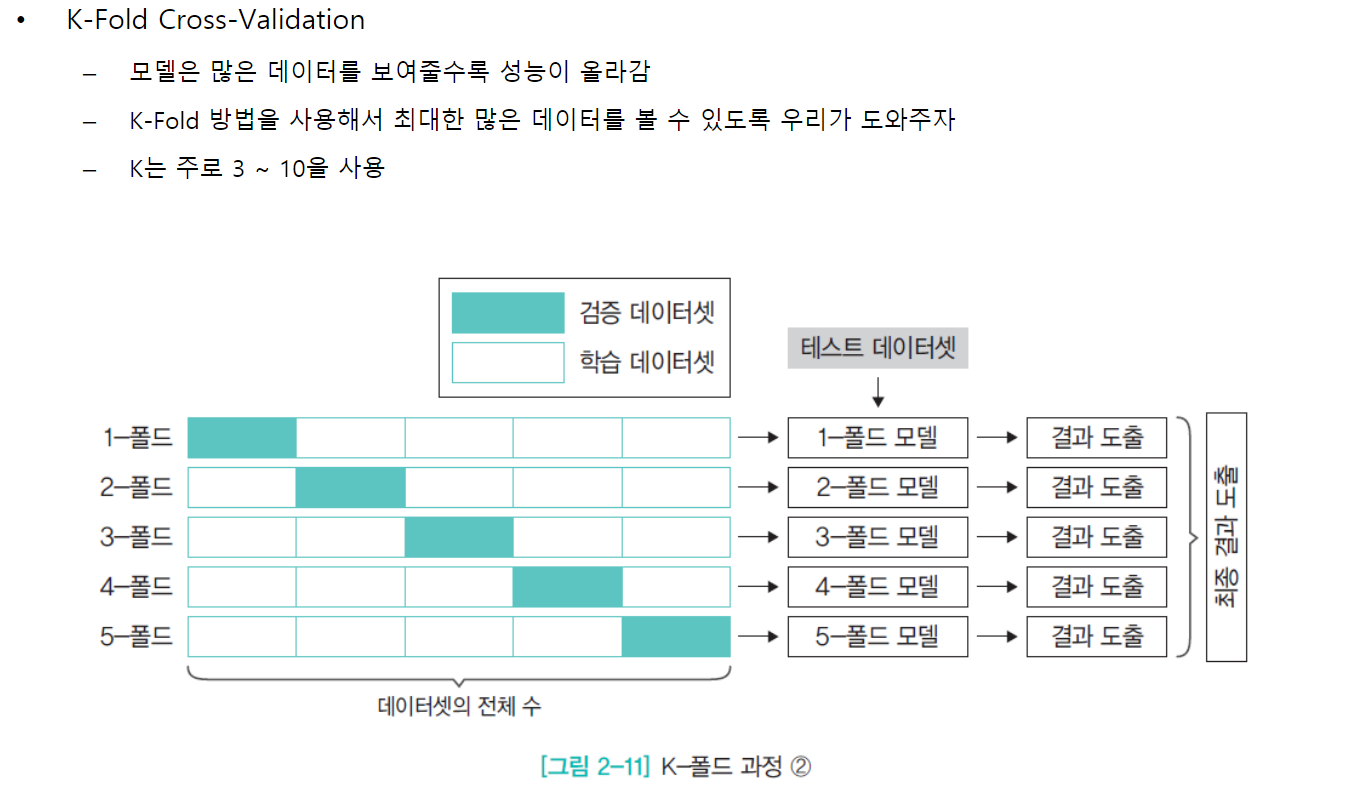

- 데이터 셋 다시 로드 및 표준화

In [30]:
from tensorflow.keras.datasets.boston_housing import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

(x_train, y_train), (x_test, y_test) = load_data(path='boston_housing.npz',
                                                 test_split=0.2,
                                                 seed=777)

# 데이터 표준화
mean = np.mean(x_train, axis = 0)
std = np.std(x_train, axis = 0)
# 여기까진 전부 동일합니다.
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

- K-Fold 정의

In [34]:
from sklearn.model_selection import KFold
#----------------------------------------
# K-Fold를 진행해봅니다.
k = 3

# 주어진 데이터셋을 k만큼 등분합니다.
# 여기서는 3이므로 훈련 데이터셋(404개)를 3등분하여
# 1개는 검증셋으로, 나머지 2개는 훈련셋으로 활용합니다.
kfold = KFold(n_splits=k, random_state = 777)

# 재사용을 위해 모델을 반환하는 함수를 정의합니다.
def get_model():
    model = Sequential()
    model.add(Dense(64, activation = 'relu', input_shape = (13, )))
    model.add(Dense(32, activation = 'relu')) 
    model.add(Dense(1))   

    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    
    return model

mae_list = [] # 테스트셋을 평가한 후 결과 mae를 담을 리스트를 선언합니다.

# k번 진행합니다.
for train_index, val_index in kfold.split(x_train):
    # 해당 인덱스는 무작위로 생성됩니다.
    # 무작위로 생성해주는 것은 과대적합을 피할 수 있는 좋은 방법입니다.
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # 모델을 불러옵니다.
    model = get_model()
    
    model.fit(x_train_fold, y_train_fold, epochs = 300, validation_data = (x_val_fold, y_val_fold), verbose=0)
    
    test_mse, test_mae = model.evaluate(x_test, y_test)
    mae_list.append(test_mae)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


4/4 [==============================] - 0s 4ms/step - loss: 9.1792 - mae: 2.1266


- K-Fold 결과 확인하기

In [35]:
print(f'전체 결과: {mae_list}')
print(f'평균낸 결과를 최종 결과로 사용합니다: {np.mean(mae_list)}')

전체 결과: [2.0690407752990723, 2.135439395904541, 2.1266276836395264]
평균낸 결과를 최종 결과로 사용합니다: 2.1103692849477134


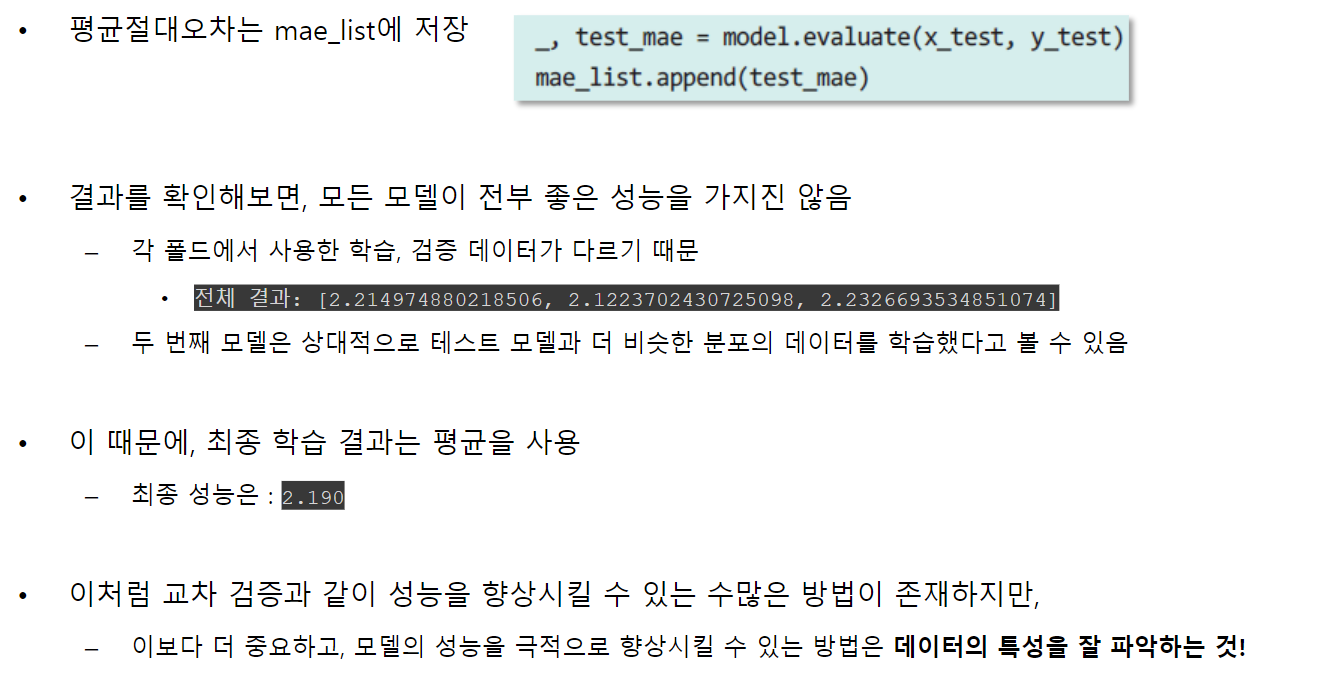